# Distilling Anchors: High-Precision Model-Agnostic Explanations

Inspired by [The Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/) blog post, which is an amazing educational resource, I decided to start this series of posts where I will try to drill down some papers that I've been reading :) The focus is to provide some dummy explanation, giving preference to use `code` and some cool vizualizations alongside with it!

This is the first blog, where I'm going to explain in details the Anchor's paper [@anchors] [^1].

[^1]: Depending on the effort that I will need to put on that I will decide if I would continue or not


![](images/annotated-anchor/anchor-introduction.jpeg "Anchor paper definition")

# Introduction

As a starting point, the authors from the paper claim that having a high level of human precision is super important when it comes to truly understanding a model's prediction.

:::{.callout-important}

It is important to endorse that **human precision** means that fraction of time where a **human** confidently predict the outcome of a model (thats not the 
same as **precision from machine learning** jargon)

:::



Building on that concept, anchors come into play. They offer high-precision rules that simplify the behavior of complex models, ensuring predictions with a high confidence level. Think of them as your trusty local guides (well, _anchors_), helping you navigate the complex lanes of your model’s prediction landscape.

Local explanation methods like LIME [@LIMEPaper] are great, but they have their limitations. They represent the model's local behavior linearly, which may not always capture the full picture (especially when extrapolating for instances). Here's where anchors shine. 

In essence, an anchor explanation is a set of 'if-then' rules (so called **anchors**). These rules assure us that the explanation holds good locally, and the algorithm tries to extend its relevance to as large an area as possible. So, as long as the anchors are in place, the prediction (almost) remains consistent, irrespective of what's happening with other features not included in the anchor. In a nutshell, anchors keep the prediction ship steady, even when other features might be creating waves.

:::{.callout-important}

By the way, my attempt here will be to explain Anchors in the context of tabular data and, at most, with text data. Please keep in mind that it is a model-agnostic model, so it works for any type of input!

:::

## Necessary Jargon

I'll take the definitions from [Alibi's documentation](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html), which are concise and really well defined :)

### Predicate

> Represents an expression involving a single feature. Some examples of predicates for a tabular dataset having features such as `Age, Relationship, and Occupation` are:
> - 28 < Age < 50
> - Relationship = Husband
> - Occupation = Blue-Collar

### Rule

>  A rule represents a set of predicates connected by the `AND` operator. Considering all the predicate examples above, we can construct the following rule:

>  `28 < Age < 50 AND Relationship = Husband AND Occupation = Blue-Collar`

Note that a rule selects/refers to a particular subpopulation from the given dataset.

### Anchor

> An anchor explanation is a **rule** that sufficiently _anchors_ the prediction locally – such that changes to the rest of the feature values of the instance do not matter [@anchors]

### Precision

> Precision represents the probability of receiving the same classification label of the explained input if we query the model on other instances that satisfy the anchor predicates. The expected precision range is the interval $[t,1]$, where $t$ is the user-specified precision threshold.

> For example, if $t=0.95$ and we have two instances, $a$ and $b$, that contains the same anchor predicates, the probability that a given model will predict the same result for both is $0.95$.

### Coverage

> Coverage represents the proportion of the population which satisfy the anchor predicates. It is a positive number $\leq 1$, where a value of corresponds $1$ to the empty anchor.

## Going Formal

Let's say we have a set of conditions or rules, which we'll call $A$. $A$ works on an easily understandable representation and it goes like this - if all conditions of $A$ are met for a specific instance (let's call it $x$), then $A(x)$ will return 1.

In our earlier example, $x$ has these feature values: `Age is between 28 and 50`, `Relationship status is 'Husband'`, and `Occupation is 'Blue-Collar'`. If these are the conditions $A$ is checking for, in this case, $A(x)$ is $1$ because all the conditions are met.


Now, suppose we have a complex model (we'll refer to it as a 'black box model'), which we'll denote as $f$, that takes input $X$ and generates output $Y$. Now, if we have a specific instance $x \in X$, our objective with local model-agnostic interpretability is to make it easy for a user to understand why $f(x)$ - the prediction for the instance $x$ - is what it is. 

The fundamental assumption here is that even if the model is too intricate to explain in a brief manner globally, if we "zoom in" on individual predictions, the task of explaining becomes feasible. In order to achieve this, most model-agnostic techniques use a process called 'perturbation', modifying the instance $x$ following a specific "perturbation distribution" which we'll denote as $\mathcal{D}$.

Assuming the definition of $A$ from before, we denote as $\mathcal{D}(\cdot|A)$ the case when conditional distribution contains the rule $A$ being applied. $A$ is called an _anchor_ if it holds true for $x$ (i.e., $A(x)=1$) and is a sufficient condition for $f(x)$ with high probability (the $\tau$ introduced before). If we sample an instance $z$ from $\mathcal{D}(z|A)$ and it's predicted as Positive in the same way as $x$ (meaning $f(x) = f(z)$), then $A$ is an anchor.

In other words:

- Given we apply the anchor $A$ to $x$, the expected probability that $f(x) = f(z)$ under the distribution $\mathcal{D}$ conditioned on $A$ is equal or greater then some threshold $\tau$.

Mathematically,

$\mathbb{E}_{\mathcal{D}(z|A)}[\mathbb{1}_{f(x)=f(z)}] \geq \tau,A(x)=1$

### Computing Anchors

 As stated before, an anchor $A$ is identified as a collection of feature predicates related to $x$, with a precision $prec(A)$ that is equal to or greater than $\tau$. This precision can be defined as follows:

$prec(A) = \mathbb{E}_{D(z|A)}[\mathbb{1}{f(x) = f(z)}]$

The authors define precision in a probabilistic manner:

> **An anchor meets the precision condition with a high level of certainty.**

$P(prec(A) \geq \tau) \geq 1 - \delta$

If there are multiple anchors that satisfy these criteria, preference is given to those that represent a larger portion of the input space, or in other words, those with the greatest **coverage**.

The coverage of an anchor $A$, $\text{cov}(A)$, is formally defined as the probability that it is applicable to samples derived from the distribution $D$. We can represent it as follows: 

$\text{cov}(A) = \mathbb{E}_{D(z)}[A(z)]$.

#### Searching the set of Anchors


Thus, our goal is to identify the set of anchors, $A$, that ensures maximum coverage. This can be achieved through the following combinatorial optimization problem:

\begin{align*}
\underset{A \text{ s.t. } , P(prec(A) \geq \tau) \geq 1 - \delta}{\text{max}}  \text{cov}(A)
\end{align*}

To accomplish this, we don't utilize a pre-existing dataset. Rather, we employ perturbation distributions along with a black box model, which are instrumental in estimating precision and coverage bounds under the distribution $\mathcal{D}$. 

For a good (and trackable) exploration of the model's behavior within the perturbation space, we map the problem to a multi-armed bandit formulation.

# Anchor Algorithm

## The Dataset

For learning purposes, let's use a simple dataset generator from scikit-learn which I trained a `LGBMClassifier`

In [1]:
#| code-fold: true

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Generate a 2D dataset with two classes
np.random.seed(42)
X, y = make_blobs(n_samples=200, centers=2, random_state=42, cluster_std=2.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the LightGBM classifier
clf = LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)

LGBMClassifier(random_state=42)

Also, I want to explain a single instance from `test` set. Let's take the first element :)

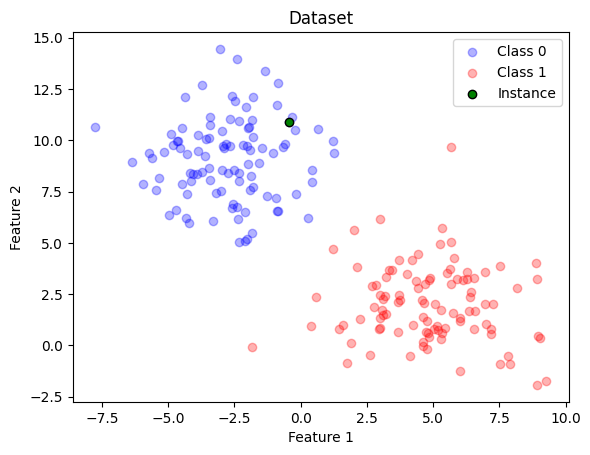

In [2]:
#| label: fig-dummy-dataset
#| fig-cap: "Dummy dataset"
#| layout-ncol: 1
#| code-fold: true

instance_to_explain = np.where(X==X_test[0])[0][0]

assert (X[instance_to_explain]==X_test[0]).all()

def plot_dataset_with_instance(X, y, highlight_row=None, title="Dataset"):
    # Assuming you have two classes 0 and 1
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Create a scatter plot for each class
    plt.scatter(class_0[:, 0], class_0[:, 1], c='blue', label='Class 0', alpha=0.3)
    plt.scatter(class_1[:, 0], class_1[:, 1], c='red', label='Class 1', alpha=0.3)
    
    if highlight_row is not None:
        plt.scatter(X[highlight_row, 0], X[highlight_row, 1], c='green', label='Instance', alpha=1, marker='o', edgecolors='k')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add a legend to the plot
    plt.legend()
    
    plt.show()

# Pass in the index of the row you want to highlight
plot_dataset_with_instance(X, y, highlight_row=instance_to_explain)

Therefore, I want to provide an explaination through `Anchors` for the `green` point, which comes from the `test set`.

In the paper, the authors separates the candidate generation from the Anchor algorithm itself. I think it is better to threat them altogether, then in other hands we can say that the whole algorithm is three fold:
1. Candidate Generation
2. Best candidate identification

## Identifying Candidates

We start by creating an 'anchor' $A$, which we initially set up as an _empty rule_ that can apply to every instance. As we iterate through our process, we come up with new potential rules that expand $A$ by adding another feature predicate, denoted as $\{a_i\}$, to its definition. In other words, with each iteration, our set of potential rules looks like $\{A \wedge a_i, A \wedge a_{i+1}, A \wedge a_{i+2}, \dots\}$, each one just adding a new feature predicate to the last.

Mathematically, the algorithm is defined as follows (taken from the paper):

![Generate Anchor Candidates](images/annotated-anchor/generate_candidates.jpeg){#fig-anchor-algo1}


### Show me the code!

Before that we have to define some intermediate functions that will help us to simplify things[^2]

[^2]: ChatGPT helped me to create this whole. It is be being a true ally for writing my posts as well :)

#### Creating Predicates

Since anchors are a set of predicates, we need to define what a Predicate is

In [3]:
#| code-fold: true
import pandas as pd
from collections import namedtuple
import numpy as np
from tqdm import tqdm

class Predicate:
    def __init__(self, feature, operator, threshold):
        self.feature = feature
        self.operator = operator
        self.threshold = threshold

    def __call__(self, x):
        if self.operator == "<=":
            return x[:, self.feature] <= self.threshold
        elif self.operator == ">":
            return x[:, self.feature] > self.threshold

    def __str__(self):
        return f'x[{self.feature}] {self.operator} {self.threshold}'
    
def generate_predicates(X_train):
    predicates = []
    for feature in range(X_train.shape[1]):
        for threshold in np.unique(X_train[:, feature]):
            predicates.append(Predicate(feature, "<=", threshold))
            predicates.append(Predicate(feature, ">", threshold))
    return predicates


:::{.callout-important}

Please note that the `generate_predicates` method that I implemented uses **unique** values from dataset train to set the rules. I decided to keep it this way to simplify things and focus on what matters. However, if we considerer real implementations, we should create rules based on **Discretization** of continuous features to reduce the search space. Also, authors claim to have used a validation dataset for $\mathcal{D}$ instead of the training set.

:::

In [4]:
#| code-fold: true

def calculate_coverage(anchor, D):
    D_sample = D.copy()
    for predicate in anchor:
        mask = predicate(D_sample)
        indices_match_anchor = np.argwhere(mask == True).flatten()
        D_sample = D_sample[indices_match_anchor]
    # D_sample is equal to the number of instances where anchor rules hold
    return len(D_sample)/len(D)

def generate_cands(anchor_set, c, X_train):
    A_r = []
    predicates = generate_predicates(X_train)
    if len(anchor_set) == 0:
        # each predicate is a potential anchor in the first round
        for predicate in predicates:
            anchor = [predicate]
            cov = calculate_coverage(anchor, X_train)
            if cov > c:
                A_r.append(anchor)
    else:
        for anchor in anchor_set:
            anchor_features = {pred.feature for pred in anchor}
            for predicate in predicates:
                # Skip predicates already in the anchor
                if predicate.feature in anchor_features:
                    continue

                # Create a new candidate anchor by adding the predicate
                A_new = anchor.copy()
                A_new.append(predicate)
                
                cov = calculate_coverage(anchor, X_train)
                if cov > c:
                    # If coverage is above threshold, add to results
                    A_r.append(A_new)
    print(f"Found {len(A_r)} new anchors with coverage above {c}")
    return A_r

Lets see a quick and simple example where we want to explain the first element of test set and the desired coverage is 0.95


:::{.callout-important}

Also, realize that the way that we defined $\mathcal{D}$ is specific for Tabular cases. For Images or Text these might difer. If you want to learn more, check [this](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html#Simple-sampling-strategies) out

:::

In [5]:
# Apply the function
A = []  # start with an empty anchor
c = 0.95  # coverage threshold, set as desired
x = X_test[0]
A_r = generate_cands(A, c, X_train)
len(A_r)

Found 26 new anchors with coverage above 0.95


26

For example, these are some candidates:

In [6]:
print(A_r[0][0])
print(A_r[10][0])
print(A_r[20][0])

x[0] > -5.959033288078816
x[0] <= 8.884191230253368
x[1] <= 11.128530580636152


## Selecting the Best Candidate


In order to determine the most suitable candidate from a given pool, the authors approach the problem by formulating it as an exploration of multi-armed bandits [@Kaufmann13]. Here, each candidate $A$ is considered as an arm, and the hidden reward is represented by the true precision of $A$ on $\mathcal{D}(\cdot|A)$. Evaluating the expression $\mathbb{1}_{f(x)=f(z)}$ on a sample drawn from $\mathcal{D}(z|A)$ corresponds to pulling the arm $A$.

The authors utilized a method called KL-LUCB (short for _Kullback-Leibler Lower Confidence Bound_), to determine the rule with the highest precision. However, explaining the intricacies of KL-LUCB in a brief blog post may be overly complex. Since our main focus is on Anchor's theory rather than Reinforcement Learning, I will simplify this part by employing an $\epsilon$-greedy approach.

### Differences into algorithm approaches

I asked ChatGPT to define this one and considering it is correct, I thought it would worth to put it here:

The **Kullback-Leibler Lower Confidence Bound** (KL-LUCB) and the **$\epsilon\text{-greedy}$** algorithms are two different approaches to the multi-armed bandit problem, which is a classical problem in probability theory and statistics that models the trade-off between exploration and exploitation in sequential decision-making.

An $\epsilon\text{-greedy}$ algorithm is a simple approach where, with probability epsilon, the algorithm chooses an arm at random (exploration). With probability $1-\epsilon$, it selects the arm with the highest estimated reward (exploitation). The value of epsilon is usually set to a small value, and it can be decreased over time to favor exploitation over exploration.

On the other hand, the KL-LUCB calculates the confidence bounds (an **upper one** and a **lower one** on the expected rewards for each option using the Kullback-Leibler divergence, which quantifies the difference between two probability distributions. This allows KL-LUCB to make more informed decisions based on the uncertainty of the rewards.

Therefore, for implementing the exploration vs. exploitation algorithm, we will not need to calculate the upper confidence and lower confidence bounds for precision, but rather we will always take the maximum precision _or_ a random one, depending on $\epsilon$ value.

:::{.callout-important}

I'll not paste the pseudo code for the other algorithms (`BestCands` and `BeamSearch`) shown in paper since I implemented variations of them by using $\epsilon \text{- greedy}$ instead of KL-LUCB

:::

In [7]:
# Function to get a sample which satisfies the rules in an anchor
def sample_conditionally(X, anchor):
    D_sample = X.copy()
    for predicate in anchor:
        mask = predicate(D_sample)
        # Use the mask to sample from the training set
        D_sample = D_sample[mask]
    #we are interested in obtaining samples from minimum size of 2
    if len(D_sample)<=1: 
        return None
    #D_sample will contain the instances where A(x)=1, where A is the anchor
    # I decided to sample half of it, but we could use other values
    rnd_indices = np.random.choice(len(D_sample), size=len(D_sample)//2)
    D_sample = D_sample[rnd_indices]
    return D_sample

# Function to estimate the precision of an anchor
def estimate_precision(clf, X_train, x, anchor):
    fx = clf.predict([x])
    z = sample_conditionally(X_train, anchor)
    if z is None: # No sample satisfies the anchor
        return 0.0
    fz = clf.predict(z)
    return (fz==fx).mean()

# Main function to find the best candidate to add to the anchor
def best_cand(anchor_candidates, X_train, x, clf, epsilon, num_samples=1000):
    if len(anchor_candidates) == 0:
        return None
    num_arms = len(anchor_candidates)
    Q = np.zeros(num_arms)
    N = np.zeros(num_arms, dtype=int)
    for _ in tqdm(range(num_samples), desc="Performing Epsilon Greedy approach"):
        if np.random.rand() < epsilon: # Explore
            arm = np.random.randint(num_arms)
        else: # Exploit
            arm = np.argmax(Q)
        anchor = anchor_candidates[arm]
        reward = estimate_precision(clf, X_train, x, anchor)
        N[arm] += 1
        Q[arm] += (reward - Q[arm]) / N[arm]
    return anchor_candidates[np.argmax(Q)]

In [8]:
best_anchor = best_cand(A_r, X_train, x, clf, 0.3, num_samples=1000)

Performing Epsilon Greedy approach: 100%|██████████| 1000/1000 [00:01<00:00, 655.34it/s]


In [9]:
#| code-fold: true

print("Anchors final rule: " + "AND ".join(str(predicate) for predicate in best_anchor))

Anchors final rule: x[0] <= 7.2508364505367595


# Going greedy

To get the complete version of the algorithm, we then implement a Greedy Search approach, based on the following parameters:
- `blackbox_model` the blackbox model that we want to explain
- `instance_to_explain` the instance that we want to analyze
- `D` the perturbation sample dataset. `X_train` in our scenario
- `epsilon`, the $\epsilon$ related to $\epsilon \text{- greedy}$ approach
- `tau` the desired precision that we want to achieve

Therefore, greedly we will always take the best candidate anchor according to previous `best_cand` implementation if its precision is above our desired threshond $\tau$ and then we **incrementaly** increases the predicates to the rule set of this given anchor until we explore the entire space

The implementation can be find below:

In [10]:
def greedy_search(blackbox_model, instance_to_explain, D, epsilon, tau, num_samples=1000):
    a_star = None
    anchor_candidates = []
    best_cov = -1
    while True:
        anchor_candidates = generate_cands(anchor_candidates, best_cov, D)
        best_candidate = best_cand(anchor_candidates, D, instance_to_explain, blackbox_model, epsilon, num_samples)
        if len(anchor_candidates) == 0:
            break
        candidate_precision = estimate_precision(clf, X_train, x, best_candidate)
        if  candidate_precision >= tau:
            cov_current = calculate_coverage(best_candidate, D)
            if cov_current > best_cov:
                a_star = best_candidate
                best_cov = cov_current
    return a_star

In [11]:
final_anchor = greedy_search(blackbox_model=clf, instance_to_explain=x, D=X_train, epsilon=0.05, tau=0.95, num_samples=1000)

Found 560 new anchors with coverage above -1


Performing Epsilon Greedy approach: 100%|██████████| 1000/1000 [00:01<00:00, 654.68it/s]


Found 150640 new anchors with coverage above 0.03571428571428571


Performing Epsilon Greedy approach: 100%|██████████| 1000/1000 [00:01<00:00, 557.12it/s]


Found 0 new anchors with coverage above 0.10714285714285714


In [12]:
#| echo: false

print("Anchors final rule: " + "AND ".join(str(predicate) for predicate in final_anchor))

Anchors final rule: x[0] > -4.891804617458048AND x[1] > 10.040820994425033


In [13]:
#| echo: false

print(f"Anchor coverage: {calculate_coverage(final_anchor, X_train)}")
print(f"Anchor precision: {estimate_precision(clf, X_train, x, final_anchor)}")

Anchor coverage: 0.10714285714285714
Anchor precision: 1.0


As we can see, there is some issues by using a Greedy approach, which we will get into details in the next section

## Issues with Greedy Search

As we can see, due to the greedy nature of the algorithm, it is impossible to search two different anchors "at the same time". At every time, it will select the _best_ candidate and incrementally augment it (so we can't backtrack, for example). Also, the greedy search does not consider coverage, so it is biased to return the shortest anchor that respects the precision $\tau$ threshold.

We can extend the greedy approach to address these issues so that **instead of taking the best candidate, we take the best $B$ ones**. Therefore, we turn a **greedy** search problem into **beam-search**. Given this set of **$B$** candidates, we search for the one with the highest coverage.

# Beam Search

In [14]:
#| code-fold: true

def best_candidate_beam(anchor_candidates, X_train, x, clf, epsilon, num_samples=1000, B=10):
    if len(anchor_candidates) == 0:
        return None
    if B > len(anchor_candidates):
        return anchor_candidates
    num_arms = len(anchor_candidates)
    Q = np.zeros(num_arms)
    N = np.zeros(num_arms, dtype=int)
    for _ in tqdm(range(num_samples), desc="Performing Epsilon Greedy approach"):
        if np.random.rand() < epsilon: # Explore
            arm = np.random.randint(num_arms)
        else: # Exploit
            arm = np.argmax(Q)
        anchor = anchor_candidates[arm]
        reward = estimate_precision(clf, X_train, x, anchor)
        N[arm] += 1
        Q[arm] += (reward - Q[arm]) / N[arm]
    top_B_indices = np.argpartition(Q, -B)[-B:] # Take the best B candidates instead of the top one
    top_B_anchors = [anchor_candidates[i] for i in top_B_indices]
    return top_B_anchors

In [15]:
#| code-fold: true

def beam_search(blackbox_model, instance_to_explain, D, epsilon, B, tau, num_samples=1000):
    a_star = None
    anchor_candidates = []
    best_cov = -1
    while True:
        anchor_candidates = generate_cands(anchor_candidates, best_cov, D)
        best_candidates = best_candidate_beam(anchor_candidates, D, instance_to_explain, blackbox_model, epsilon, num_samples, B)
        if len(anchor_candidates) == 0:
            break
        for candidate in best_candidates: #iterate over the beam search results
            candidate_precision = estimate_precision(clf, X_train, x, candidate)
            if candidate_precision >= tau:
                cov_current = calculate_coverage(candidate, D)
                if cov_current > best_cov:
                    a_star = candidate
                    best_cov = cov_current
    return a_star

In [16]:
final_anchor = beam_search(blackbox_model=clf, instance_to_explain=x, D=X_train, epsilon=0.05, B=10, tau=0.95, num_samples=1000)

Found 560 new anchors with coverage above -1


Performing Epsilon Greedy approach:   4%|▍         | 38/1000 [00:00<00:10, 95.29it/s]

Performing Epsilon Greedy approach: 100%|██████████| 1000/1000 [00:02<00:00, 489.93it/s]


Found 85680 new anchors with coverage above 0.45


Performing Epsilon Greedy approach: 100%|██████████| 1000/1000 [00:01<00:00, 726.94it/s]


Found 0 new anchors with coverage above 0.45714285714285713


In [17]:
print("Anchors final rule: " + "AND ".join(str(predicate) for predicate in final_anchor))

Anchors final rule: x[1] > 5.038647509945887AND x[0] <= 3.0942284071529578


In [18]:
calculate_coverage(final_anchor, X_train)

0.45714285714285713

In [19]:
estimate_precision(clf, X_train, x, final_anchor)

1.0

This concludes the step-by-step simplified explanation of the Anchor algorithm. However, in a real world scenarios, we don't expect to implement such an algorithm from scratch (also, this is _reeeeeeeeally_ low performative due to maintaining that as didactic as possible). For that, we can rely on really awesome libraries, such as [alibi](https://github.com/SeldonIO/alibi)

# Show me the ~~real~~ example

I could use a sample dataset for that, but this would increase the lenght of this post, but I will use a simple boilerplate code for alibi code such that it could be easily extensible for other datasets :)

In [20]:
from alibi.explainers import AnchorTabular

explainer = AnchorTabular(clf.predict, feature_names=clf.feature_name_)
explainer.fit(X_train)

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.3'}
)

Some considerations:
- `batch_size` is the size of sample size used, which was half of the dataset in our examples
- `coverage_sample` is the number of times we repeat the sampling process for calculating coverage. We sampled just one for the entire dataset in our case

In [21]:
explanation = explainer.explain(x, threshold=0.95, batch_size=100, beam_size=10)

print("Anchors final rule: " + " AND ".join(str(predicate) for predicate in explanation.anchor))

Anchors final rule: Column_1 > 4.35 AND Column_0 <= 1.94


In [22]:
#| code-fold: true

print(f"Anchor precision: {explanation.precision}")
print(f"Anchor coverage: {explanation.coverage}")

Anchor precision: 0.9897959183673469
Anchor coverage: 0.4639


## A real example

Thanks to my [master's advisor](https://www.ime.usp.br/~ddm/), I got access to a simple dataset which could be used to mimic a real workd example. Let's take a look at it

### The dataset

The dataset is straightforward. We have the following columns:
- region, which is the geographic region of Brazil
- UF, which is the state/county 
- City, the city itself
- latitude and longitude
- temperature and altitude

In [23]:
#|echo: false
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/temp-alt-2020.csv", index_col=0).reset_index(drop=True)
df.head()

,region,UF,city,lat,lon,temperature,altitude
0,SE,RJ,CAMPOS DOS GOYTACAZES - SAO TOME,"-22,04166666","-41,05166666",24.002001,-41.051667
1,CO,MT,SAO FELIX DO ARAGUAIA,"-11,61888888","-50,72777777",26.947313,-50.727778
2,N,PA,MARABA,"-5,366447","-49,051166",26.410281,-49.051166
3,CO,GO,RIO VERDE,"-17,785303","-50,964869",27.305761,-50.964869
4,S,RS,PORTO ALEGRE,"-30,05361111","-51,17472221",19.983030,-51.174722


Then, let's try to predict a given region from Brazil. Using latitude, longitude, city and UF would be straightfoward (think about inference time, if you have the one of these four, it would be straitghfoward to compute the region). Therefore, let's use the `temperature` and `altitude` to predict the region :)

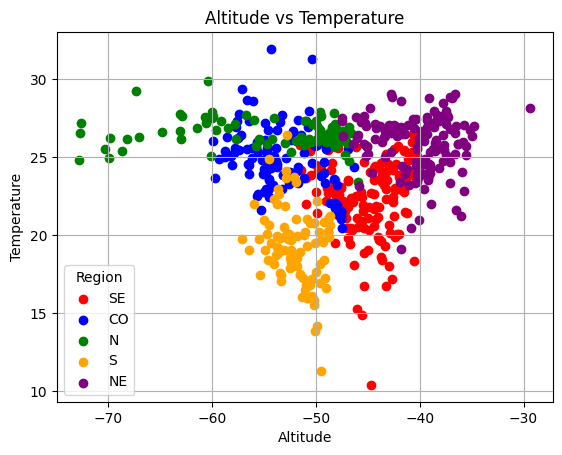

In [24]:
#| label: fig-geography-dataset
#| fig-cap: "Brazilian regions with Altitude and Temperature"
#| layout-ncol: 1
#| code-fold: true

colors = {"SE": 'red', "CO": 'blue', "N": 'green', "S": 'orange', "NE": 'purple'}
FEATURE_COLUMNS = ["altitude", "temperature"]
LABEL_COLUMN = "region"
df = df[FEATURE_COLUMNS+[LABEL_COLUMN]]

def plot_data(df):
    for region in df["region"].unique():
        plt.scatter(df[df["region"]==region]["altitude"],
                    df[df["region"]==region]["temperature"],
                    color=colors[region],
                    label=region)
    plt.xlabel('Altitude')
    plt.ylabel('Temperature')
    plt.title('Altitude vs Temperature')
    plt.legend(title='Region')
    plt.grid(True)
    plt.show()

plot_data(df)

There is some clear decision boundary for some classes, e.g. 

- if $\text{tempertature} \leq 20$ and $-60 \leq \text{altitude} \leq -50$ then there is a high chance that we are talking about _South_ region (orange points).
-  Similarly,  if $25 \leq \text{tempertature} \leq 30$ and $-70 \leq \text{altitude} \leq -60$ then there is a high chance that we are talking about _North_ region (green point). 

Let's see if given a blackbox model we can learn anchros with similar patterns :)

Cross-validation scores:  [0.8021978  0.85714286 0.7032967  0.76923077 0.84444444]
Average cross-validation score:  0.7952625152625152


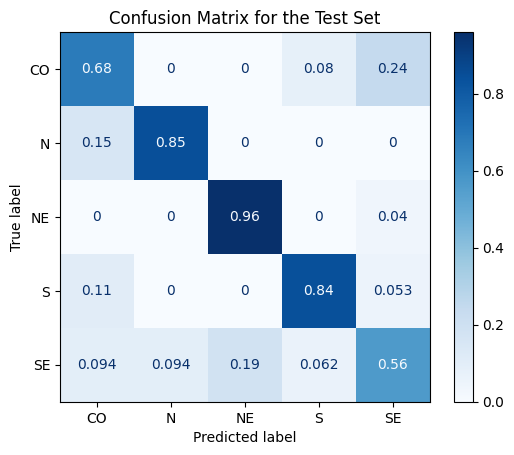

In [25]:
#| label: fig-confusion-matrix-real-dataset
#| fig-cap: "Test Confusion Matrix for Geography Example"
#| layout-ncol: 1
#| code-fold: true

from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay


encoder = LabelEncoder()


X_train, X_test, y_train, y_test = train_test_split(df[FEATURE_COLUMNS], df[LABEL_COLUMN], test_size=0.2, random_state=42)

encoded_labels_train = encoder.fit_transform(y_train)
encoded_labels_test = encoder.transform(y_test)
# Train the LightGBM classifier

clf = LGBMClassifier(random_state=42, class_weight="balanced")
# Cross validation
cv = StratifiedKFold(n_splits=5)

scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
print('Cross-validation scores: ', scores)
print('Average cross-validation score: ', scores.mean())
clf.fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X=X_test,
    y=y_test, 
    normalize='true', cmap="Blues", xticks_rotation="horizontal")
_ = disp.ax_.set_title("Confusion Matrix for the Test Set")

We got pretty good results for the test set, specially regarding `NE`, `S` and `N` regions. Let's see some learnt Anchors for some examples.

In [26]:
#| code-fold: true
from alibi.explainers import AnchorTabular

north_south_sample_idx = y_test[y_test.isin(['N','S'])].head().index.tolist()
explainer = AnchorTabular(clf.predict, feature_names=clf.feature_name_)
explainer.fit(X_train.values, disc_perc=tuple(sorted([i for i in range(5,100,5)]+[99])))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {
              'seed': None,
              'disc_perc': (5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 99)}
            ,
  'version': '0.9.3'}
)


:::{.callout-note}

Due to feature distribution, I also changed the _percentile dicretizer_ to a higher value than default (that is (25, 50, 75))

:::

In [27]:
#| code-fold: true

pd.set_option('display.max_colwidth', 100)

anchors = []
for example_idx in north_south_sample_idx:
    instance_to_analyze = X_test.loc[example_idx,:].values.copy()
    explanation = explainer.explain(instance_to_analyze, threshold=0.95, batch_size=100, beam_size=10)
    anchors_rule = " AND ".join(str(predicate) for predicate in explanation.anchor)
    anchor_instance = {"Test index": example_idx, 
                       "Model prediction": clf.predict(instance_to_analyze.reshape(1,-1)),
                       "Anchor precision": explanation.precision,
                        "Anchor rules": anchors_rule
                       }
    anchors.append(anchor_instance)
pd.DataFrame(anchors)

,Test index,Model prediction,Anchor precision,Anchor rules
0,208,[S],0.954071,temperature <= 22.48 AND -58.77 < altitude <= -48.81
1,420,[S],0.984615,temperature <= 20.84 AND altitude <= -48.81
2,257,[N],0.965649,temperature > 26.31 AND altitude <= -58.77
3,556,[N],0.963087,26.00 < temperature <= 27.26 AND -50.36 < altitude <= -47.07
4,185,[N],0.954198,26.00 < temperature <= 27.26 AND -50.36 < altitude <= -47.07


The predictions seems preety reasonable and if we check the @fig-geography-dataset image again, the learnt rules are somehow aligned with our initial hypothesis, which is cool :)

# Conclusion

I hope that this blog post provided more insights about Anchors algorithms and its applications. For more explanations, please refer to main paper [@anchors] (especially if you want to learn about the KL-LUCB setting and its relationship with other definitions, such as the probabilistic meaning of precision and the $\delta$ hyperparameter), [the alibi documentation](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) provides really valuable resources and [Anchor's Chapter from Interpretable ML book](https://christophm.github.io/interpretable-ml-book/anchors.html)